In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
def moulti_fit(sujet, trial, max_step=14):
    with open('data/enregistrement_%s_%s.pkl'%(sujets[sujet], times[sujet]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[sujet], times[sujet])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    data_full = read_edf(datafile, 'TRIALID')

    Plot.plot_fit(data_full, trials=trial, fitted_data='position', fig_width=30, plot_detail=None, equation='fct_position')

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    
    data_deg = A.data_deg(arg.data_x, before_sacc=5, after_sacc=15, **arg)
    rere = Fit.Fit_trial(data_deg, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti,
                         equation='fct_position', **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] : result_full_data[k] = result_full_data[k]-(arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = []
    for step in range(20) :
        color.append([])
        a = [0,0,0]
        a[step%3] = 0.15*(int(step/3)+1) #/(i+1)
        for i in range(step+2) :
            color[step].append(tuple(a))

    result_red_data = []

    N = len(velocity)-(len(arg.saccades)*3)
    for n, step in enumerate(np.arange(2, max_step)) :
        result_red_data.append([])
        for i in np.arange(step) :
            #print(step, i)
            
            lala = np.random.permutation(N)[:int(.5*N)] #[:int(.31*N)]
            
            veve = np.copy(velocity)
            veve[len(arg.saccades)*3:][lala] = np.nan
            
            dada = np.copy(data_deg)
            dada[len(arg.saccades)*3:][lala] = np.nan
            
            value_latency, value_steady_state, value_anti = A.classical_method.Full(veve, arg.TargetOn-arg.t_0)
            rere = Fit.Fit_trial(dada, value_latency=value_latency, value_steady_state=value_steady_state, 
                                 value_anti=value_anti, equation='fct_position', **arg)
            result_red = rere.values
            nb_nan = len(dada[int(result_red['latency']):-280])/len([x for x in dada[int(result_red['latency']):-280] if np.isnan(x)])
            result_red['steady_state'] = result_red['steady_state']/nb_nan
            #===================================================================
            plt.plot(arg.trackertime-arg.TargetOn, dada, c=color[n][i], alpha=.3);

            sacc = np.zeros(len(arg.trackertime))
            i_=0
            for s in range(len(arg.saccades)) :
                sacc[i_]   = arg.saccades[s][0] # onset sacc
                sacc[i_+1] = arg.saccades[s][1] # end sacc
                sacc[i_+2] = arg.saccades[s][2] # time sacc
                i_ = i_+3
            
            
            fit = A.Equation.fct_position(arg.trackertime[:-280]-arg.t_0, arg.data_x[:-280], sacc[:-280], **result_red)
            plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, color[n][i])
            
            for k in ['latency', 'start_anti'] : result_red[k] = result_red[k]-(arg.TargetOn-arg.t_0)
            result_red_data[n].append(result_red)
            
    return(result_full_data, result_red_data)

In [4]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    x_range = {'steady_state': [5, 40],
               'a_anti':       [-40, 40],
               'latency':      [75, 300],
               'start_anti':   [-500, 75],
               'tau':          [13, 80]}

    
    
    list_, list_var = x_range.keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(x_range)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                for i in range(len(result_red_data[n])) :
                    result_v.append(result_red_data[n][i][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'ref: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

AM


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

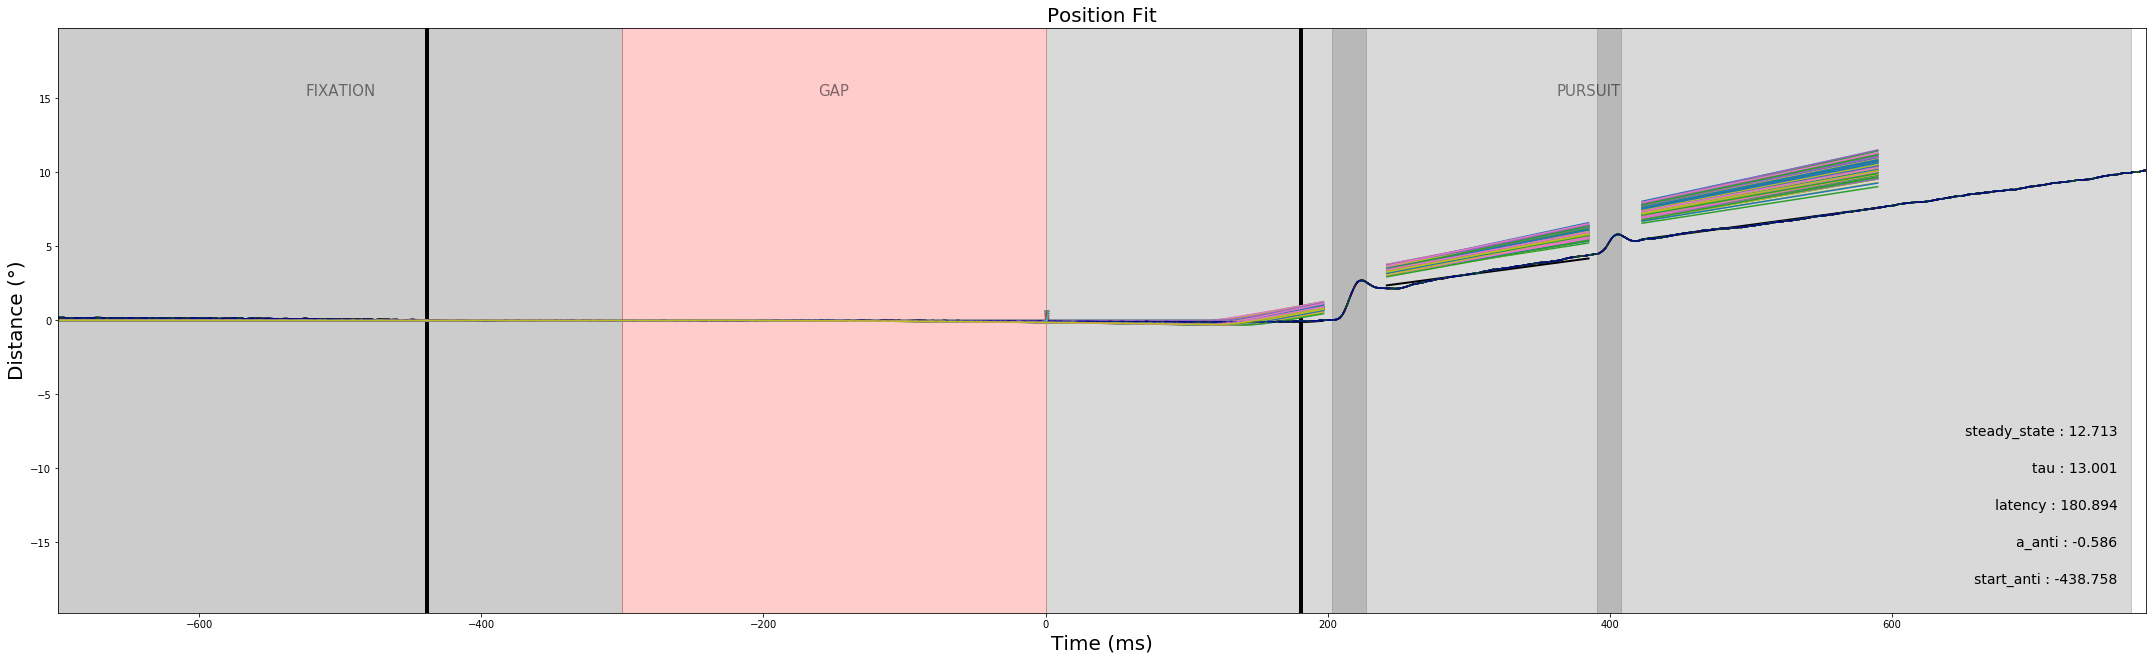

In [5]:
s, t = 0, 11
print(sujets[s])
result_full_data_s0, result_red_data_s0 = moulti_fit(s, t)

CS


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

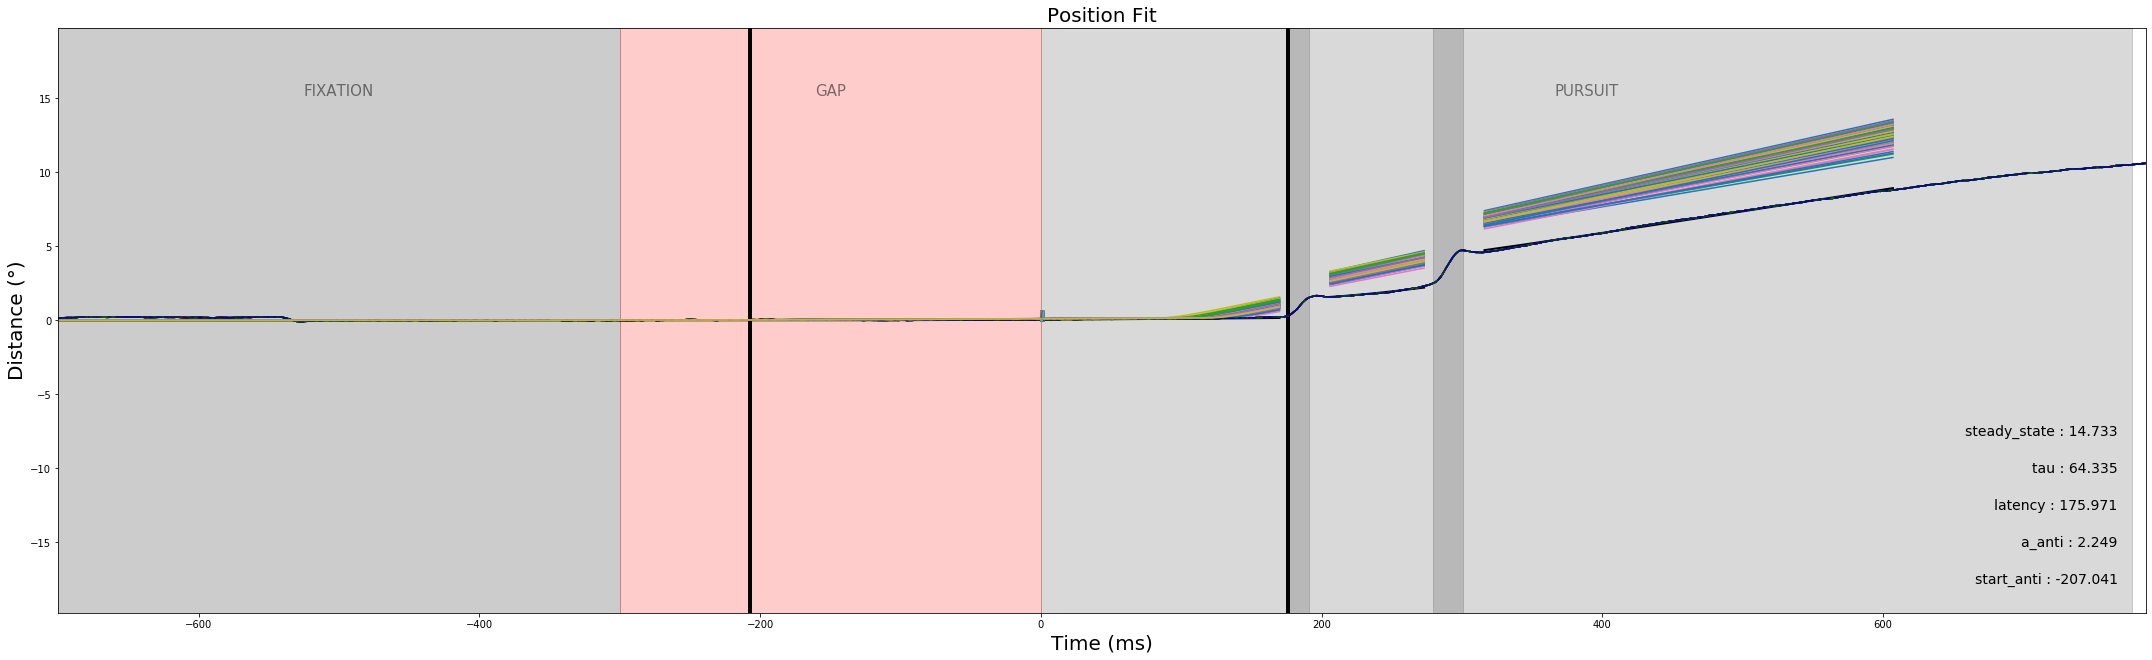

In [6]:
s, t = 2, 11
print(sujets[s])
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

DC


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

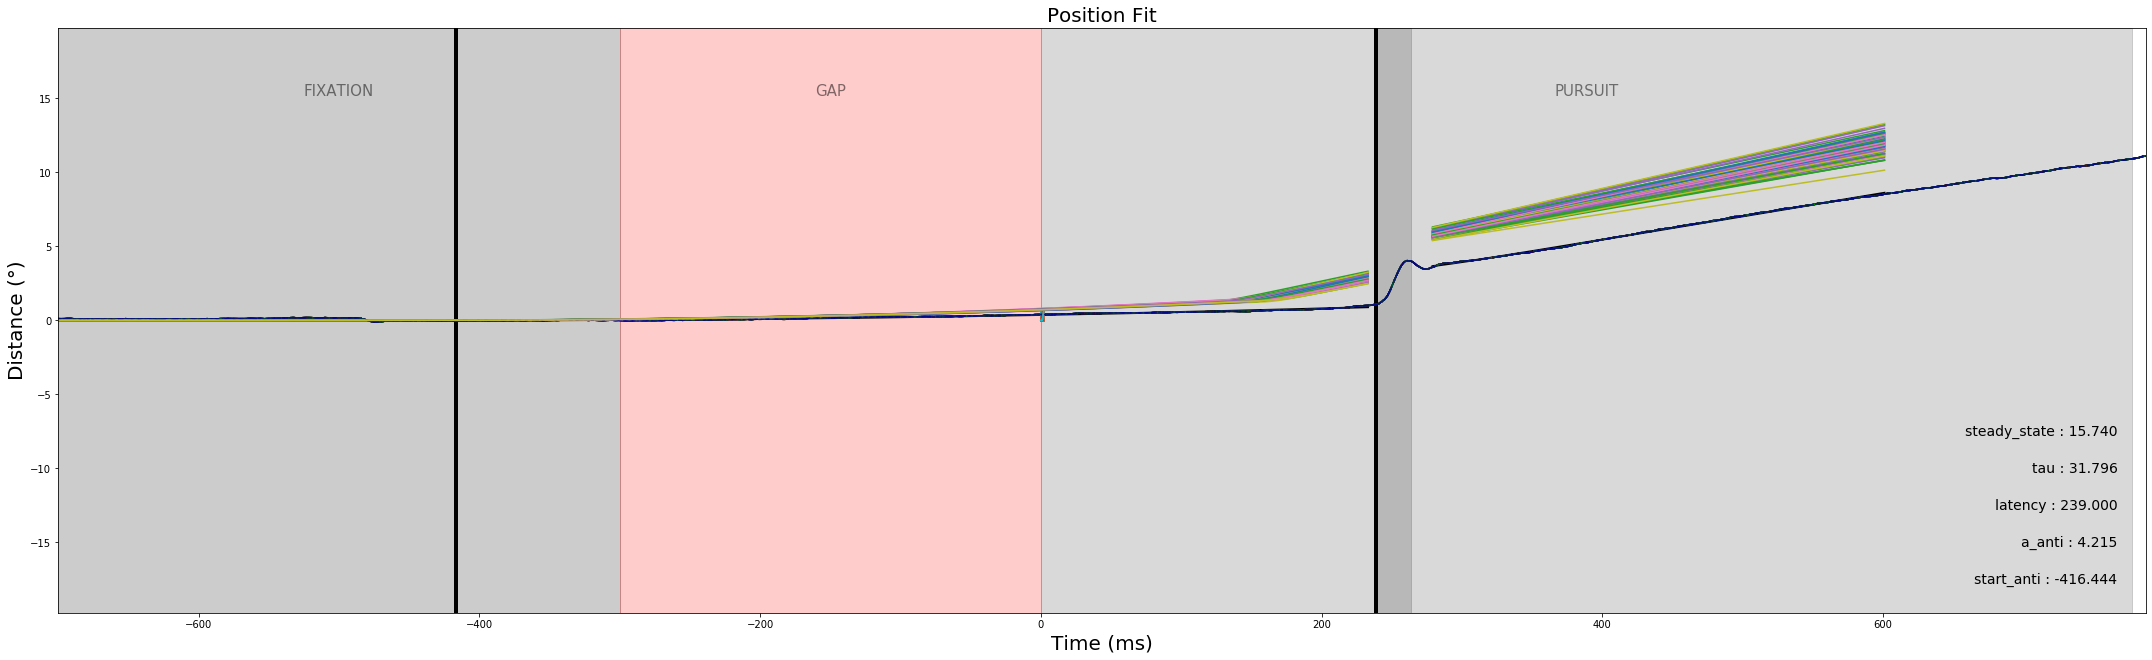

In [7]:
s, t = 3, 11
print(sujets[s])
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

IP


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: divide by zero encountered in double_scalars
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jv

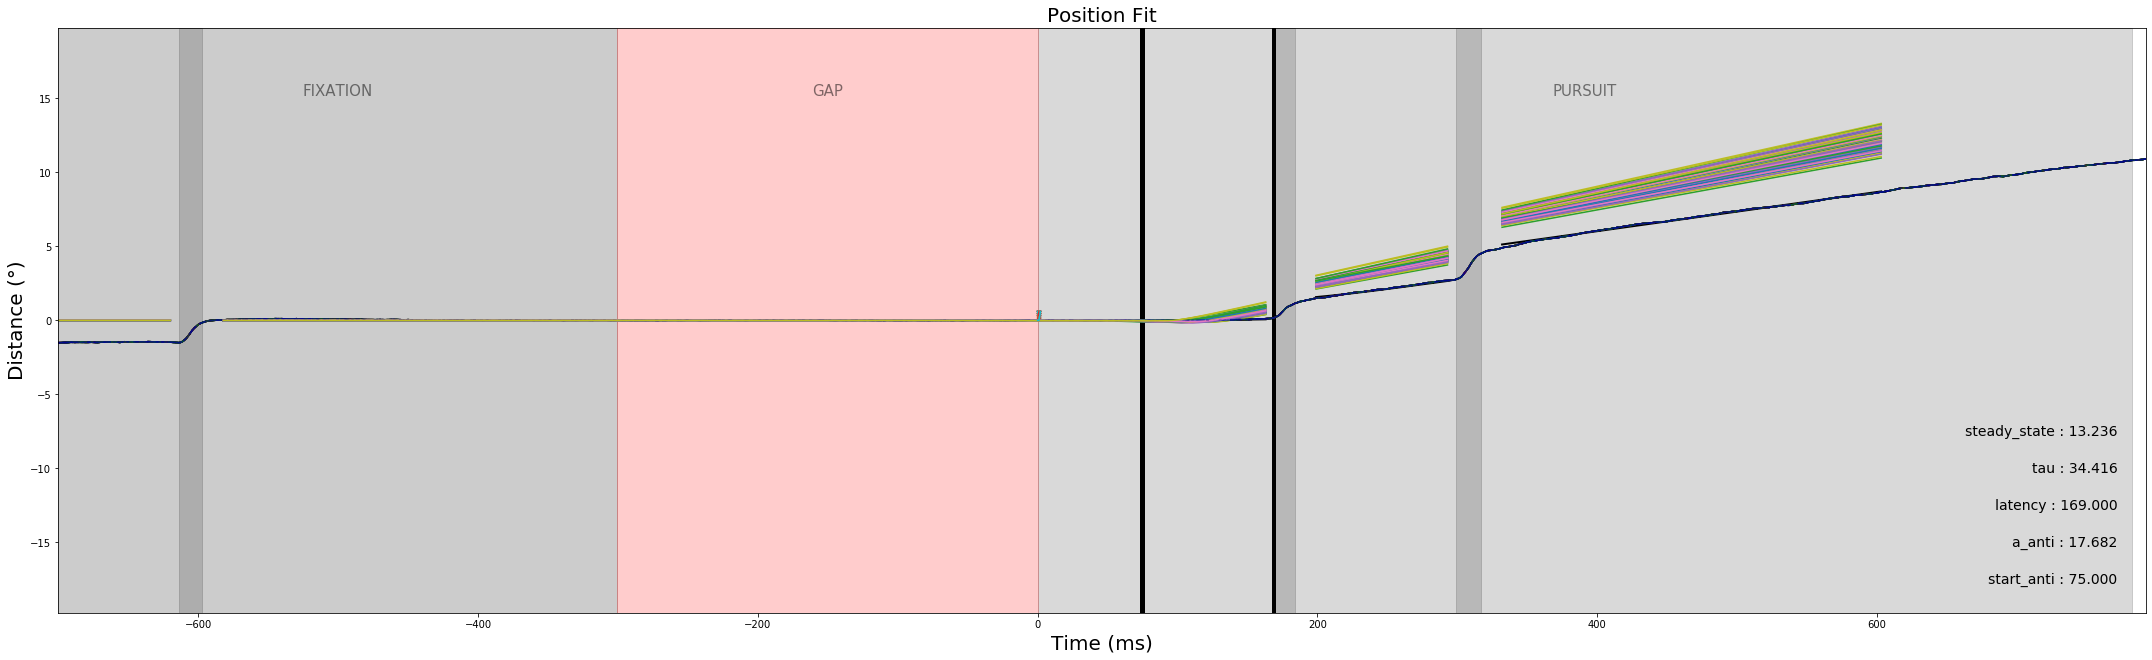

In [8]:
s, t = 5, 11
print(sujets[s])
result_full_data_s5, result_red_data_s5 = moulti_fit(s, t)

# Bad

YK


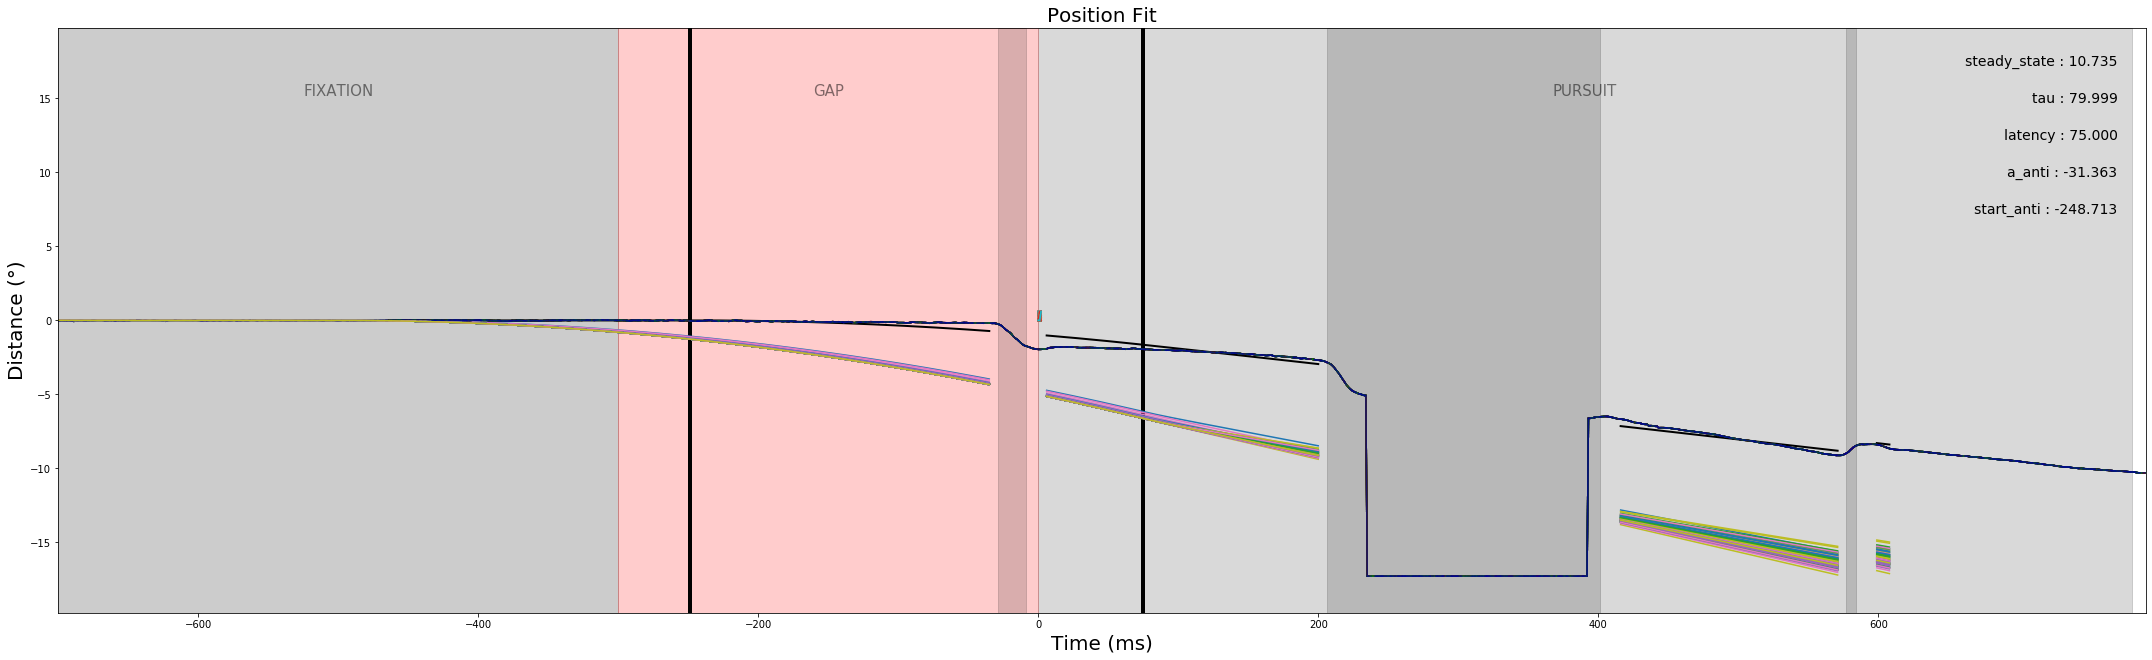

In [9]:
s, t = 11, 58
print(sujets[s])
result_full_data_s11_58, result_red_data_s11_58 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

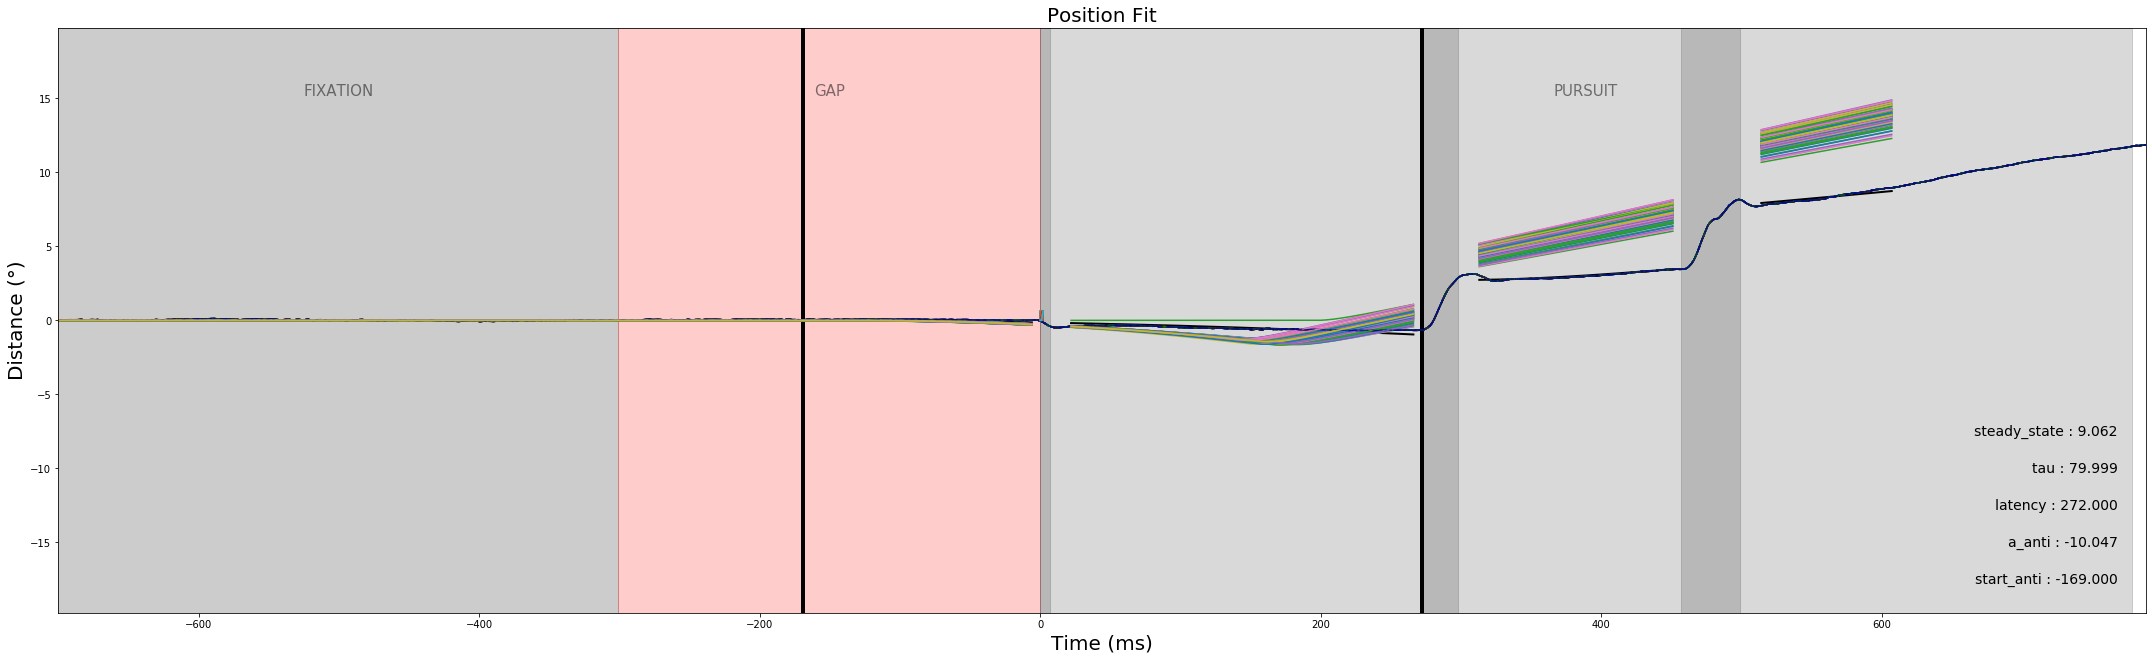

In [10]:
s, t = 11, 82
print(sujets[s])
result_full_data_s11_82, result_red_data_s11_82 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

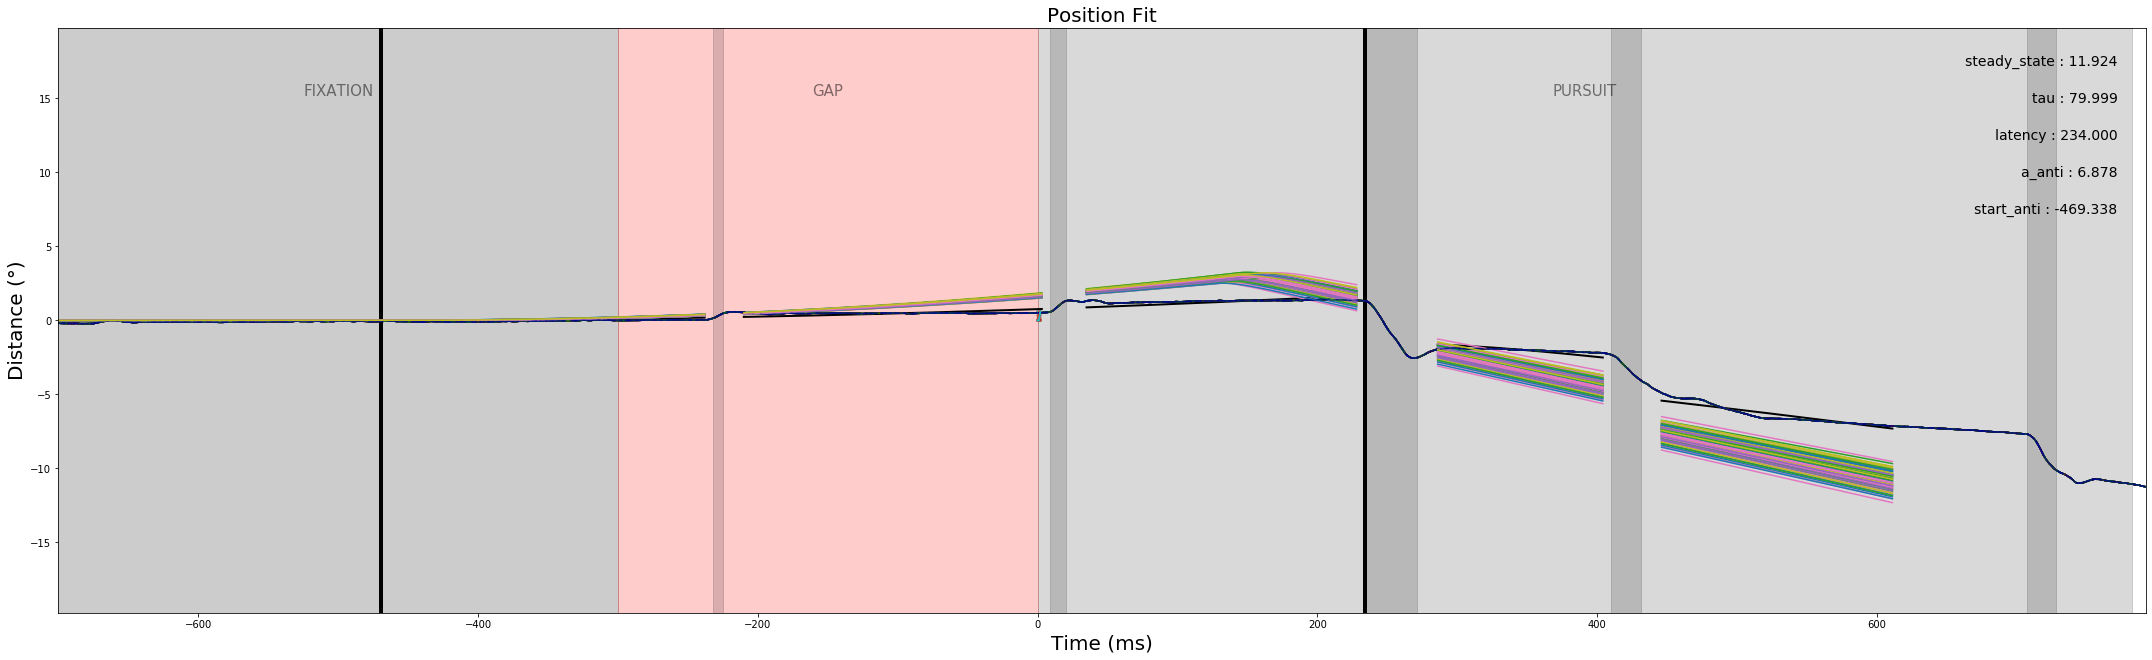

In [11]:
s, t = 11, 190
print(sujets[s])
result_full_data_s11_190, result_red_data_s11_190 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

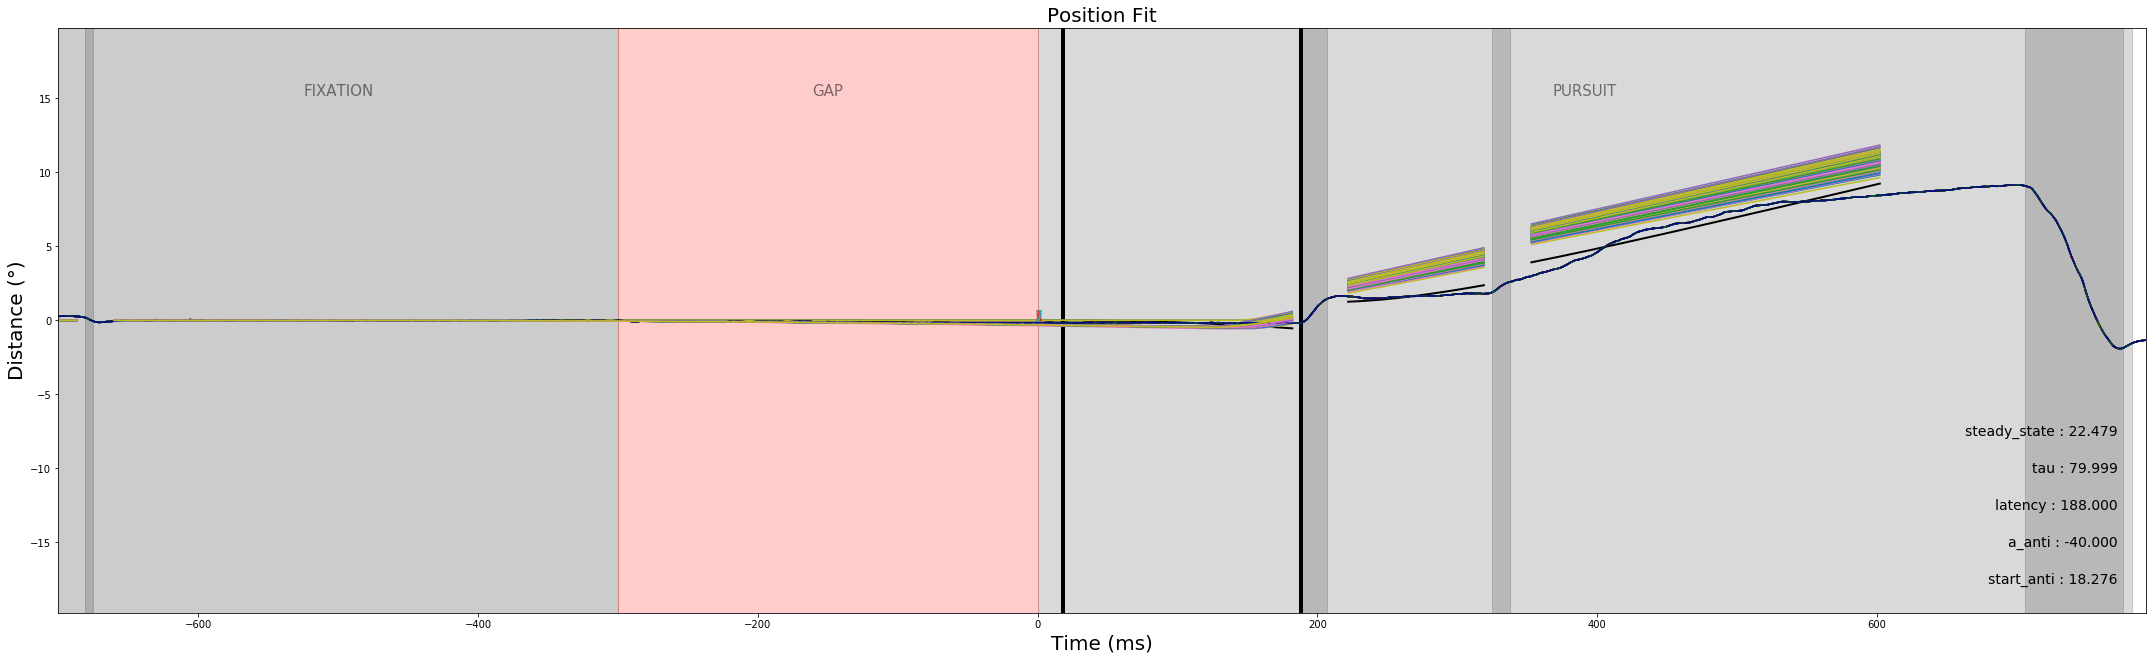

In [12]:
s, t = 11, 191
print(sujets[s])
result_full_data_s11_191, result_red_data_s11_191 = moulti_fit(s, t)

# Hist

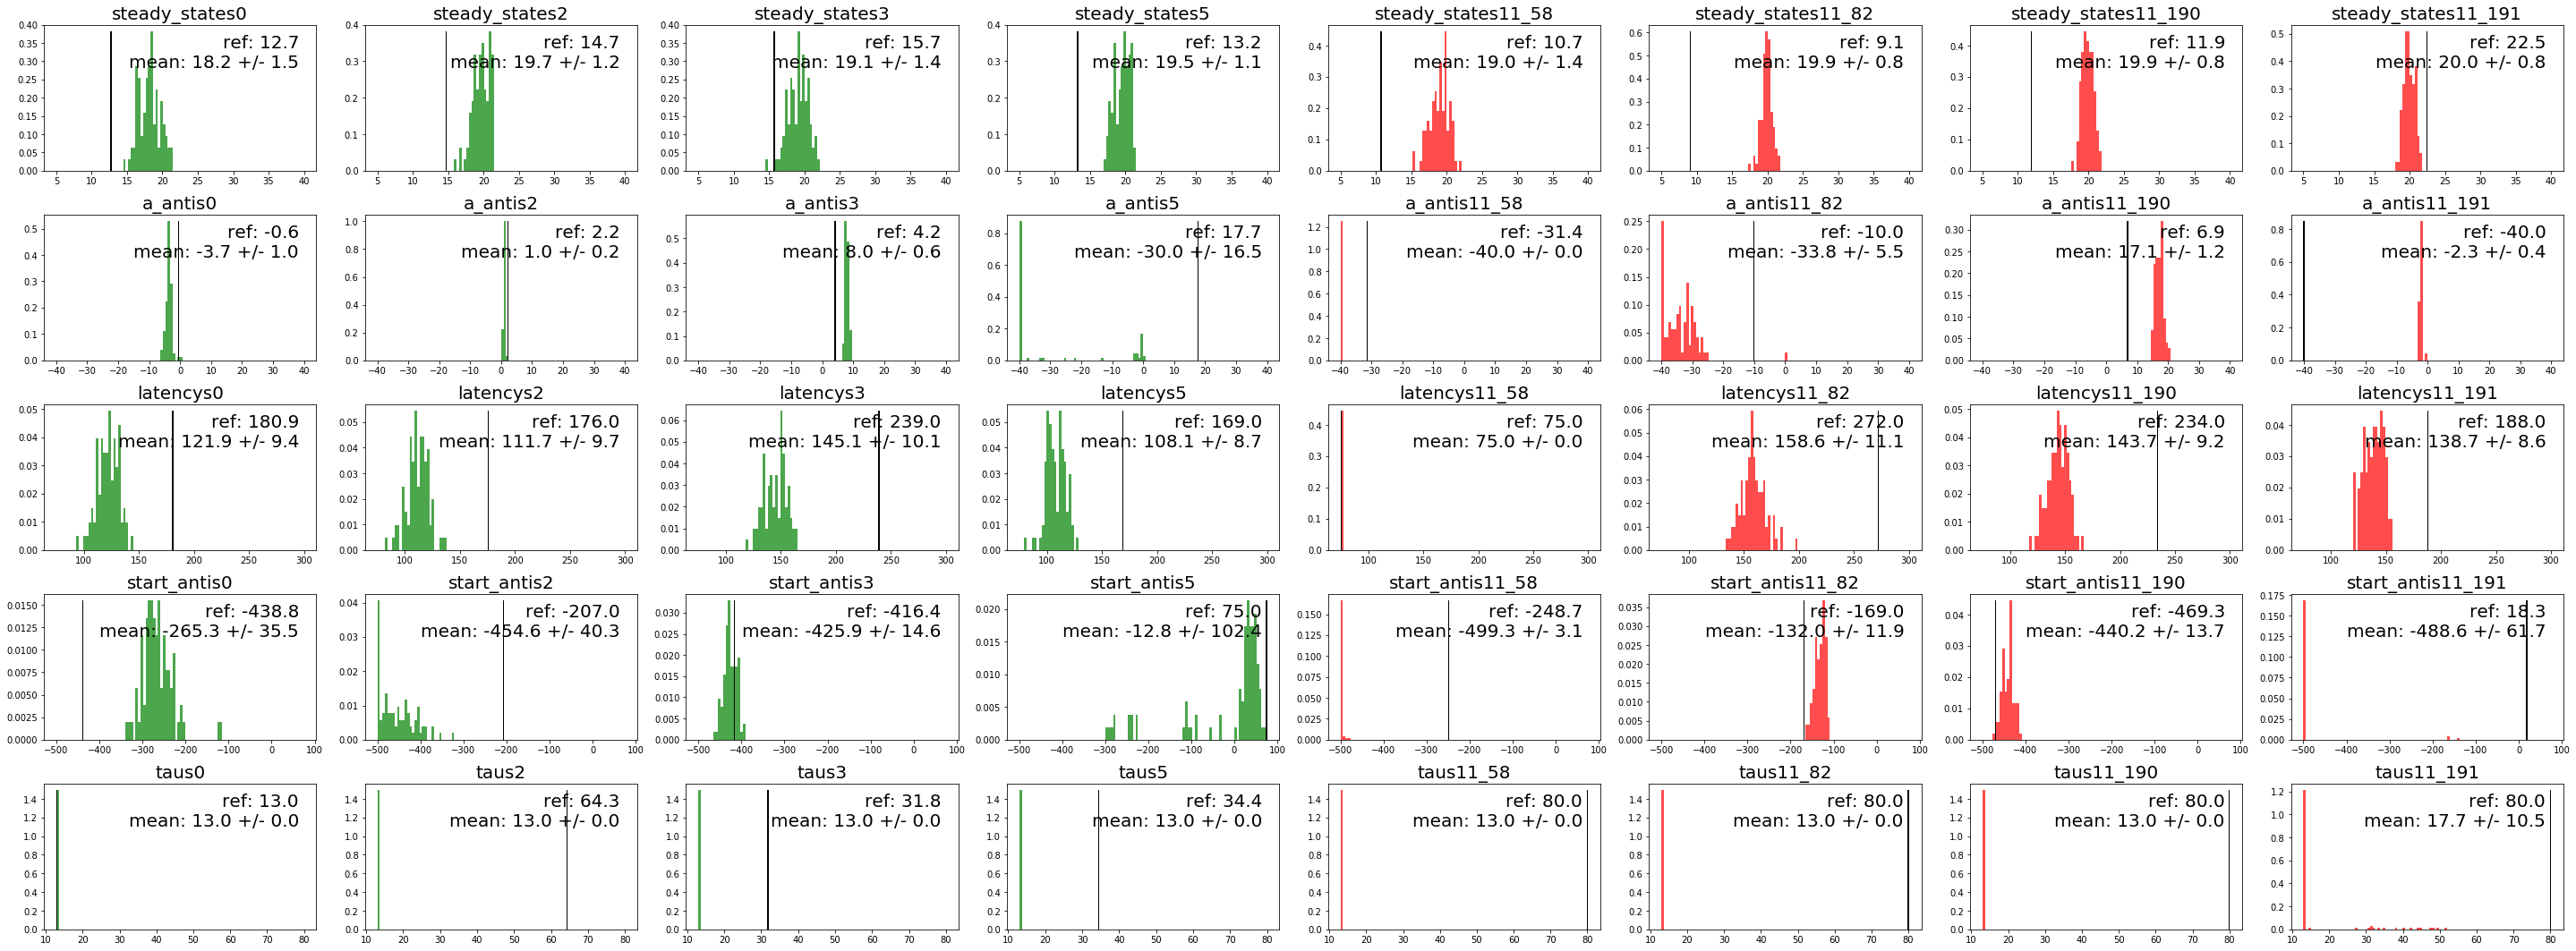

In [13]:
histoto([result_full_data_s0, result_full_data_s2, result_full_data_s3, result_full_data_s5,
         result_full_data_s11_58, result_full_data_s11_82, result_full_data_s11_190, result_full_data_s11_191],
        [result_red_data_s0, result_red_data_s2, result_red_data_s3, result_red_data_s5,
         result_red_data_s11_58, result_red_data_s11_82, result_red_data_s11_190,result_red_data_s11_191],
        ['s0', 's2', 's3', 's5', 's11_58', 's11_82', 's11_190', 's11_191'],
        [ 'g',  'g',  'g',  'g',      'r',      'r',       'r',       'r'], bins=100)